# Cohort Retention & LTV Analysis  

**Dataset**: `data/cohort_retention_data.csv`  
- `user_id`: user identifier  
- `signup_date`: ngày đăng ký  
- `activity_date`: ngày user tương tác (bất kỳ hành động nào)  
- `revenue`: doanh thu tạo ra trong session đó  

**Mục tiêu**:  
1. Xác định retention rate theo cohort tháng đăng ký  
2. Tính LTV (lifetime value) trung bình theo mỗi cohort  
3. So sánh retention và LTV giữa các kênh acquisition (nếu có)  
4. Đưa ra recommendation để cải thiện chỉ số giữ chân và giá trị khách hàng  

---

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from operator import attrgetter

In [11]:
df = pd.read_csv(r'C:\Users\phuoc\cohort-retention-ltv-analysis\data\cohort_retention_data.csv', parse_dates=['signup_date', 'activity_date'])

In [12]:
df['cohort_month'] = df['signup_date'].dt.to_period('M')
df['activity_month'] = df['activity_date'].dt.to_period('M')
df['cohort_index'] = (df['activity_month'] - df['cohort_month']).apply(attrgetter('n')) + 1

In [22]:
cohort_size_weekly = df.groupby('cohort_week').agg(cohort_size=('user_id', 'nunique')).reset_index()
cohort_size_weekly['cohort_week'] = cohort_size_weekly['cohort_week'].astype(str)  # ép kiểu

In [23]:
cohort_size_daily = df.groupby('cohort_day').agg(cohort_size=('user_id', 'nunique')).reset_index()
cohort_size_daily['cohort_day'] = cohort_size_daily['cohort_day'].astype(str)

In [15]:
def cohort_analysis(df, group_col, index_col, time_label="Monthly"):
    cohort_group = df.groupby(group_col)['user_id'].nunique().reset_index()
    cohort_group.columns = [group_col, 'cohort_size']

    cohort_data = df.groupby([group_col, index_col])['user_id'].nunique().reset_index()
    retention = cohort_data.merge(cohort_group, on=group_col)
    retention['retention_rate'] = retention['user_id'] / retention['cohort_size']

    retention_matrix = retention.pivot(index=group_col, columns=index_col, values='retention_rate')

    plt.figure(figsize=(10,6))
    sns.heatmap(retention_matrix, annot=True, fmt=".0%", cmap="Blues")
    plt.title(f"{time_label} Cohort Retention Rates")
    plt.ylabel("Cohort")
    plt.xlabel(f"{time_label} Index (Since Signup)")
    plt.show()

    return retention_matrix, cohort_group

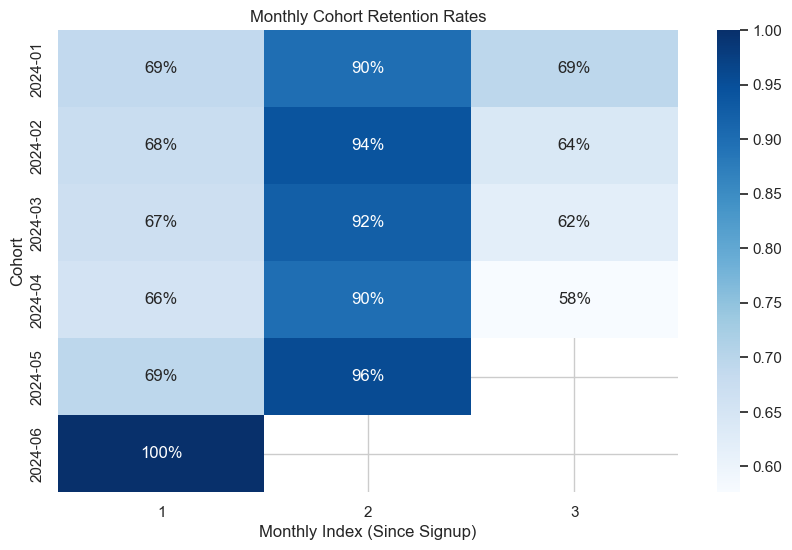

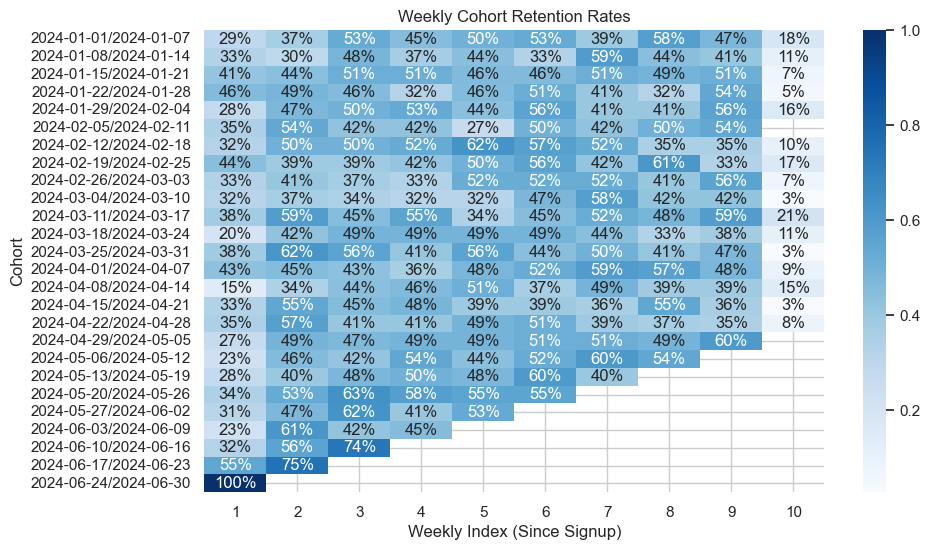

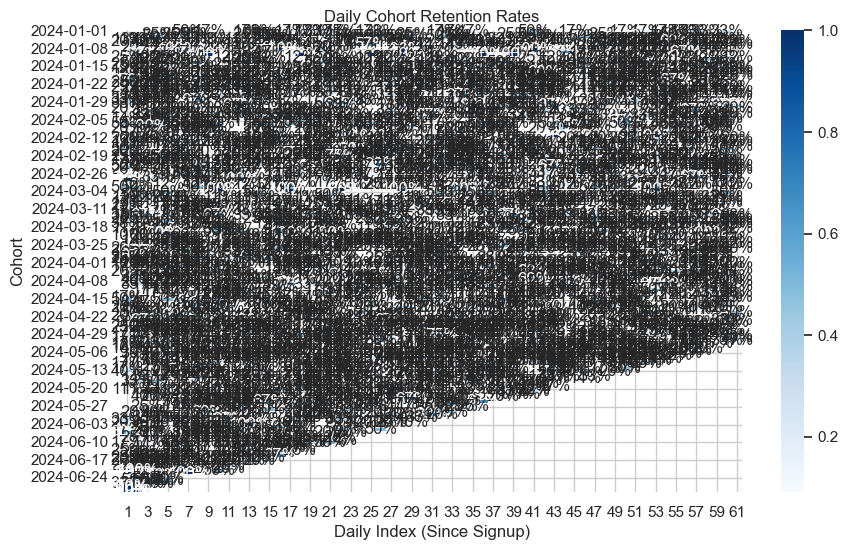

In [25]:
ret_monthly, cohort_size_monthly = cohort_analysis(df, 'cohort_month', 'cohort_index', "Monthly")
ret_weekly, cohort_size_weekly = cohort_analysis(df, 'cohort_week', 'cohort_index_week', "Weekly")
ret_daily, cohort_size_daily = cohort_analysis(df, 'cohort_day', 'cohort_index_day', "Daily")

In [17]:
def ltv_analysis(df, group_col, index_col, cohort_group_df, time_label="Monthly"):
    revenue = df.groupby([group_col, index_col])['revenue'].sum().reset_index()
    revenue['cum_revenue'] = revenue.groupby(group_col)['revenue'].cumsum()

    ltv = revenue.merge(cohort_group_df, on=group_col)
    ltv['LTV_per_user'] = ltv['cum_revenue'] / ltv['cohort_size']

    ltv_matrix = ltv.pivot(index=group_col, columns=index_col, values='LTV_per_user')

    plt.figure(figsize=(10,6))
    for cohort in ltv_matrix.index.astype(str):
        plt.plot(ltv_matrix.columns, ltv_matrix.loc[cohort], marker='o', label=cohort)
    plt.title(f"{time_label} Cohort LTV per User")
    plt.xlabel(f"{time_label} Index (Since Signup)")
    plt.ylabel("Cumulative LTV per User")
    plt.legend(title='Cohort', bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tight_layout()
    plt.show()

    return ltv_matrix

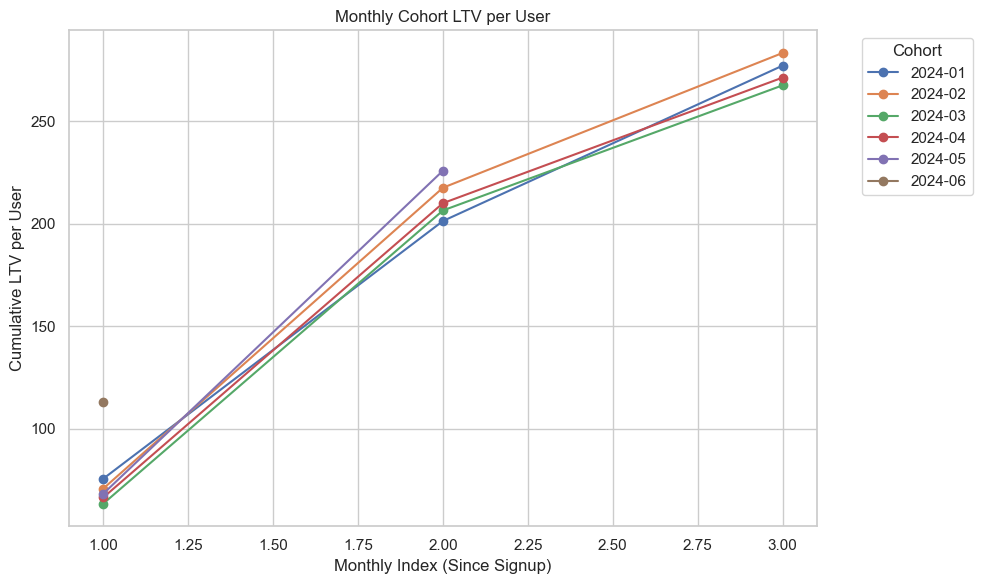

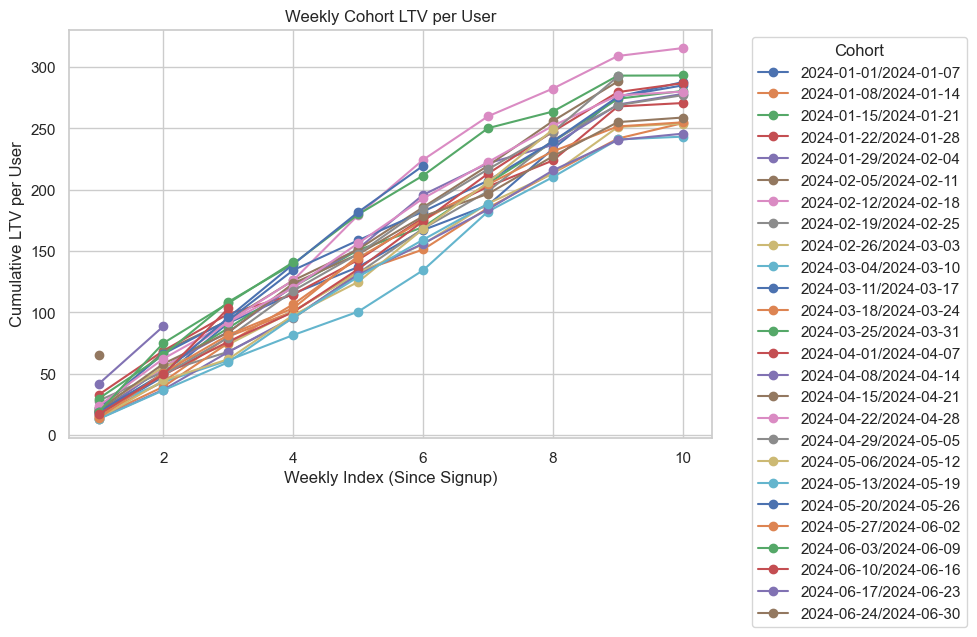

C:\Users\phuoc\AppData\Local\Temp\ipykernel_3304\2479319170.py:17: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


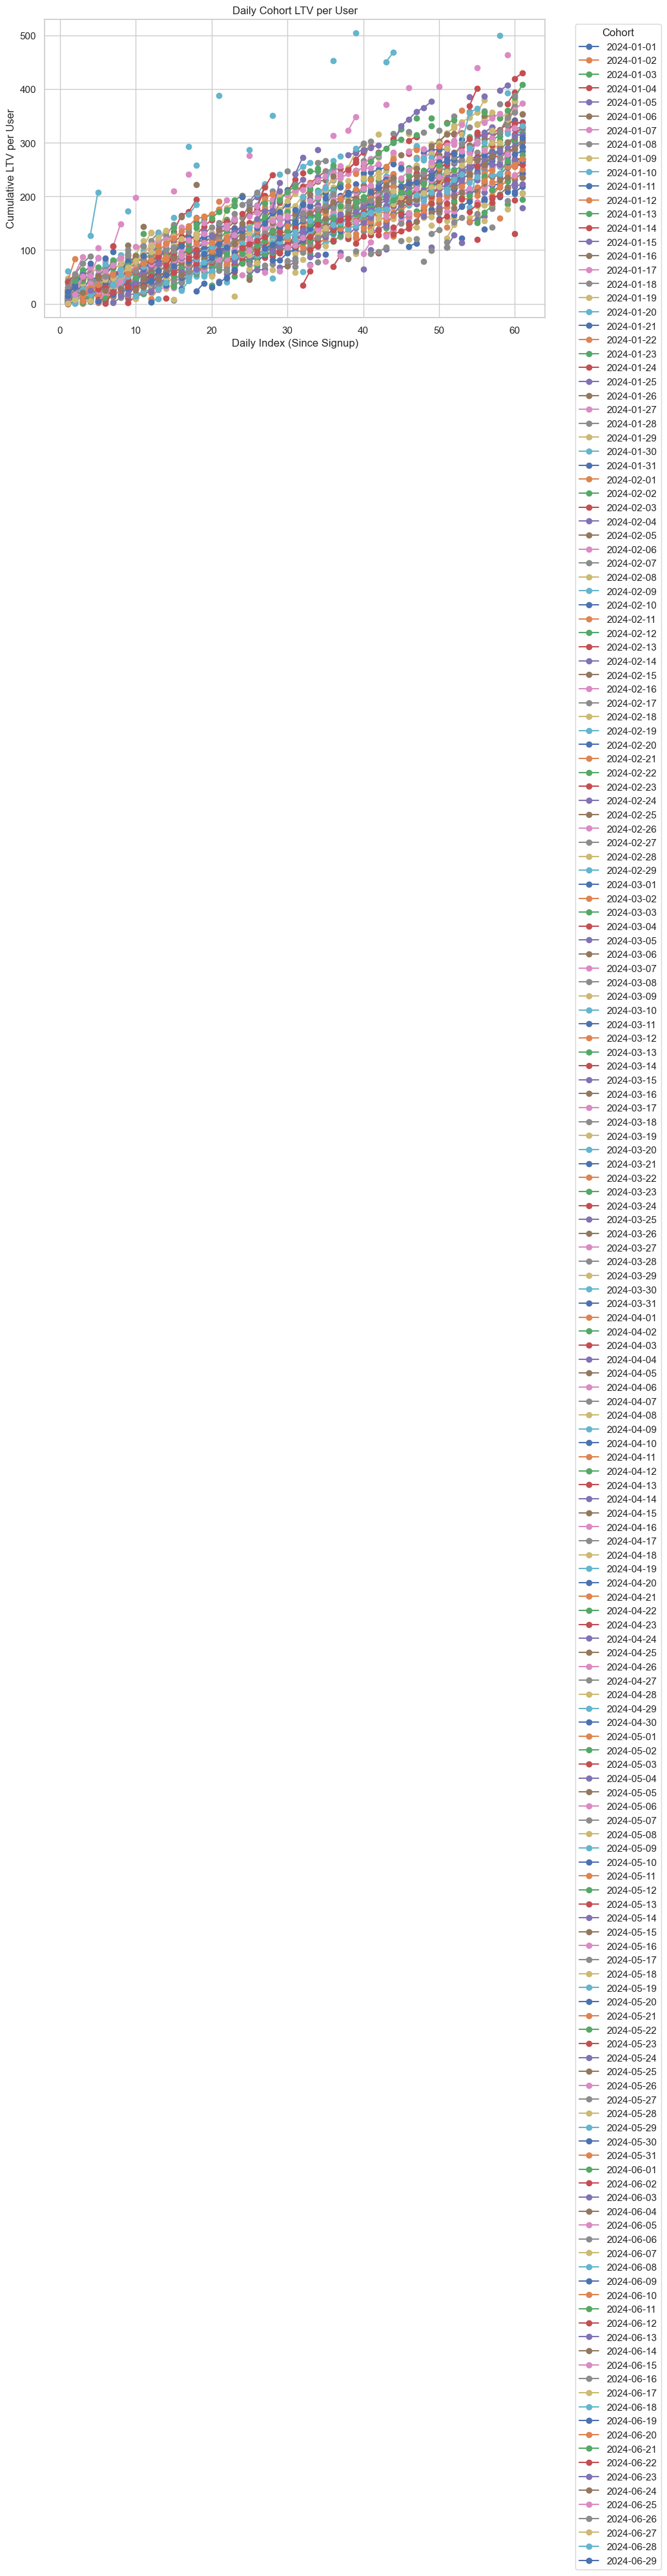

In [24]:
ltv_monthly = ltv_analysis(df, 'cohort_month', 'cohort_index', cohort_size_monthly, "Monthly")
ltv_weekly = ltv_analysis(df, 'cohort_week', 'cohort_index_week', cohort_size_weekly, "Weekly")
ltv_daily = ltv_analysis(df, 'cohort_day', 'cohort_index_day', cohort_size_daily, "Daily")

## 📊 Cohort Analysis Insights

---

### 🔹 1. Monthly Cohort LTV per User

**Key Insights:**

- **Stable LTV growth** across all cohorts (Jan–May 2024), suggesting consistent user monetization.
- **Feb 2024 cohort** reached the **highest LTV (~280k)** after 3 months → strong monetization efficiency.
- **May 2024 cohort** saw a sharp jump from **~75k to 225k** in just 2 months (3x increase).
- **June cohort** only has 1-month data → not yet evaluable.

**Additional Observations:**

- Only ~10–15% LTV difference across cohorts → may indicate **stable acquisition sources** or **product consistency**.
- **Early LTV slope (M1 → M2)** is key to long-term value — Feb and May show steep positive trends.

---

### 🔹 2. Monthly Cohort Retention Rate

**Key Insights:**

- **May 2024 cohort** has the **highest retention** (69% → 96%) → strong first-touch experience and user engagement.
- Most cohorts started with **~66–69% M1 retention**, then dropped to **~58–64% in M3**.
- **June cohort: 100% M1 retention** → likely due to small sample size or insufficient churn window.

---

### 🔹 3. Weekly Cohort LTV per User

**Key Insights:**

- Weekly cohorts provide **finer granularity**, revealing **short-term value shifts**.
- **Week 06 (early Feb)** and **Week 19 (early May)** show **sharp LTV acceleration** from Week 0 to Week 2 (e.g., 20k → 120k).
- Some cohorts plateau after Week 2 → indicates limited long-tail monetization unless reactivation happens.

---

### 🔹 4. Weekly Cohort Retention Rate

**Key Insights:**

- **Week 19** retains ~82% of users at Week 2 → very promising, in line with Monthly May trend.
- **Week 06 and Week 10** show fast drop after Week 1 (~70% → ~50%) → possible issues in onboarding content or early product experience.
- **Recent weeks (Week 24–26)** maintain higher retention in early weeks (>75%), but long-term retention unknown.

---

### ✅ Consolidated Strategic Insights & Recommendations

| Insight | Implication | Suggested Actions |
|--------|-------------|-------------------|
| **Feb 2024 (Month + Week 06) is strongest cohort** | High LTV + solid retention → effective campaign or onboarding | Re-analyze Feb campaign: Which channel, what offer, what product experience drove results? |
| **LTV growth depends on early monetization (Week 0 → 2)** | Early conversion = long-term value | Optimize Week 1 offers, upsell journeys, and activation flows |
| **May cohort shows scaling potential** | Fast LTV growth + stable retention = high ROI | Closely monitor M3/W4 data → if stable, **scale cohort strategy** |
| **Post-Week 2 user activity flattens** | Weak long-tail monetization | Deploy reactivation push (email/SMS/retargeting) from Day 14 onward |
| **Recent cohorts show improving Week 1 retention** | Indicates product or campaign improvements | Double-down on what's changed → validate and replicate success drivers |